In [1]:
import json
import os
from collections import defaultdict
import numpy as np
from torch.utils.data import Dataset
import torch



class FEMNIST(Dataset):
    """
    This dataset is derived from the Leaf repository
    (https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
    dataset, grouping examples by writer. Details about Leaf were published in
    "LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.
    """

    def __init__(self, train=True, transform=None, target_transform=None, ):
        super(FEMNIST, self).__init__()
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        train_clients, train_groups, train_data_temp, test_data_temp = read_data("./data/femnist/train",
                                                                                 "./data/femnist/test")
        if self.train:
            self.dic_users = {}
            train_data_x = []
            train_data_y = []
            for i in range(len(train_clients)):
                if i == 100:
                    break
                self.dic_users[i] = set()
                l = len(train_data_x)
                cur_x = train_data_temp[train_clients[i]]['x']
                cur_y = train_data_temp[train_clients[i]]['y']
                for j in range(len(cur_x)):
                    self.dic_users[i].add(j + l)
                    train_data_x.append(np.array(cur_x[j]).reshape(28, 28))
                    train_data_y.append(cur_y[j])
            self.data = train_data_x
            self.label = train_data_y
        else:
            test_data_x = []
            test_data_y = []
            for i in range(len(train_clients)):
                cur_x = test_data_temp[train_clients[i]]['x']
                cur_y = test_data_temp[train_clients[i]]['y']
                for j in range(len(cur_x)):
                    test_data_x.append(np.array(cur_x[j]).reshape(28, 28))
                    test_data_y.append(cur_y[j])
            self.data = test_data_x
            self.label = test_data_y

    def __getitem__(self, index):
        img, target = self.data[index], self.label[index]
        img = np.array([img])
        # img = Image.fromarray(img, mode='L')
        # if self.transform is not None:
        #     img = self.transform(img)
        # if self.target_transform is not None:
        #     target = self.target_transform(target)
        return torch.from_numpy((0.5-img)/0.5).float(), target

    def __len__(self):
        return len(self.data)

    def get_client_dic(self):
        if self.train:
            return self.dic_users
        else:
            exit("The test dataset do not have dic_users!")
def batch_data(data, batch_size, seed):
    '''
    data is a dict := {'x': [numpy array], 'y': [numpy array]} (on one client)
    returns x, y, which are both numpy array of length: batch_size
    '''
    data_x = data['x']
    data_y = data['y']

    # randomly shuffle data
    np.random.seed(seed)
    rng_state = np.random.get_state()
    np.random.shuffle(data_x)
    np.random.set_state(rng_state)
    np.random.shuffle(data_y)

    # loop through mini-batches
    for i in range(0, len(data_x), batch_size):
        batched_x = data_x[i:i + batch_size]
        batched_y = data_y[i:i + batch_size]
        yield (batched_x, batched_y)


def read_dir(data_dir):
    clients = []
    groups = []
    data = defaultdict(lambda: None)

    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.json')]
    for f in files:
        file_path = os.path.join(data_dir, f)
        with open(file_path, 'r') as inf:
            cdata = json.load(inf)
        clients.extend(cdata['users'])
        if 'hierarchies' in cdata:
            groups.extend(cdata['hierarchies'])
        data.update(cdata['user_data'])

    clients = list(sorted(data.keys()))
    return clients, groups, data



def read_data(train_data_dir, test_data_dir):
    '''parses data in given train and test data directories

    assumes:
    - the data in the input directories are .json files with
        keys 'users' and 'user_data'
    - the set of train set users is the same as the set of test set users

    Return:
        clients: list of client ids
        groups: list of group ids; empty list if none found
        train_data: dictionary of train data
        test_data: dictionary of test data
    '''
    train_clients, train_groups, train_data = read_dir(train_data_dir)
    test_clients, test_groups, test_data = read_dir(test_data_dir)

    assert train_clients == test_clients
    assert train_groups == test_groups

    return train_clients, train_groups, train_data, test_data



In [2]:
import matplotlib
import argparse
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch
import torch.nn as nn # import modules

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models_v1.Update import LocalUpdate
from models_v1.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, MobileNetV2, LeNet5, LeNet10
from models_v1.Fed import FedAvg
from models_v1.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models_v1.test import test_img

%load_ext autoreload
%autoreload 2
from torch.autograd import grad
parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
parser.add_argument('--index', type=int, default="25",
                    help='the index for leaking images on CIFAR.')
parser.add_argument('--image', type=str,default="",
                    help='the path to customized image.')
args = parser.parse_args([])
from torch.autograd import grad

In [3]:
class my_argument:    
    epochs = 400    #"rounds of training"
    num_users = 100  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=10 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.001 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'ADAM'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='femnist' #, help="name of dataset")
    iid=0
    num_classes=62#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    model='mlp'
    q=20
    f_size=32
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cpu")
args.device = torch.device("cuda:1" if use_cuda else "cpu")
print(args.device)

True
cuda:1


In [4]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient, weight_vectorization_gen2


In [5]:
def phiQ(p,sc, q, w):
    w_cap = w #[:,0]
    #w_cap=[item[0] if isinstance(item,list) and len(item)>0 else item for item in w_cap]
    #w_cap=np.array(w_cap)
    #print("w_cap_first")
    #print(w_cap)
    w_cap= sc*w_cap
    v=np.floor(q*w_cap)
    one=np.ones(len(w))
    r=np.random.uniform(0,1,len(w_cap))
    temp=(one.T+np.sign(q*w_cap-v-r))*np.sign(q*w_cap-v-r)
    #j=np.sign(w_cap-v-r)
    #print("jjj")
    #print(j)
    #temp= (1/q)*(1/2)*temp
    temp=(1/2)*temp
    #print("temp")
    #print(temp)
    #w_cap= (1/q)*v + temp
    w_cap=(1/q)*(v+temp)
    w_cap=q*w_cap
    #w_cap=w_cap+ (1/2)*p*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    w_cap=w_cap+ (1/2)*(p-5)*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    #print("w_cap_last")
    #print(w_cap)
    del temp
    del one
    del v
    del r
    return w_cap

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('/data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('/data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
        print('iid dataset')
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
        print("non iid dataset")
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
elif args.dataset == 'femnist':
    dataset_train = FEMNIST(train=True)
    dataset_test = FEMNIST(train=False)
    dict_users = dataset_train.get_client_dic()
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape


In [6]:
print(dataset_train[0][0])

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [7]:
def toNumpyFlatArray(self):
        return self.flat


def updateFromNumpyFlatArray(self, arr):
    self.flat = arr
    start = 0
    new_glob = OrderedDict()
    for k in self.w_glob.keys():
        size = 1
        for dim in self.w_glob[k].shape:
            size *= dim
        shaped = np.reshape(arr[start : start + size].copy(), self.w_glob[k].shape)
        new_glob[k] = torch.from_numpy(shaped)
        start = start + size
    self.w_glob = new_glob
    self.net_glob.load_state_dict(self.w_glob)

In [8]:
beta=[1,1/2,1/4,1/8,1/16]
beta=[1,1,1/2,1/2,1/4]
beta=[1,1,1,1,1]

comp=[]
i=0
for j in range(args.num_users):
    comp.append(beta[i])
    if (j>0 and j%20==0):
        i+=1


In [9]:
print(comp)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
#print(dict_users[2])

In [ ]:
#print(dict_users[10])

In [ ]:
print(len(dict_users[2]))

# 1. FedAvg with A=0

In [10]:

local_lr = 1e-4
local_steps = 1
use_updates = True

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, torch.nn.Linear):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.BatchNorm2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        #conv1.bias.data.fill_(0.01)

In [12]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient
import numpy as np
import copy
import random
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == "mobilenetv2":
    net_glob = MobileNetV2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    print(len_in)
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.apply(weights_init)
net_glob.train()

784
MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=62, bias=True)
)


MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=62, bias=True)
)

In [13]:
w_glob=net_glob.state_dict()
#torch.save(w_glob, "linear_FEMNIST.pt")

In [14]:
print(len_in)
print(img_size)
print(args.num_classes)

784
torch.Size([1, 28, 28])
62


In [15]:
def update_local_model( w_hold,w_local, sub):
    count=0
    for i in sub:
            w_glob_hold['layer_input.weight'][int(50*i):int(50*(i+1)),:]=w_local['layer_input.weight'][count*50:(count+1)*50,:]
            
            #combined=torch.concatenate((first,middle),axis=0)
    
            w_glob_hold['layer_input.bias'][int(50*i):int(50*(i+1))]=w_local['layer_input.bias'][count*50:(count+1)*50]
            
    
    
            w_glob_hold['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]=w_local['layer_hidden.weight'][:,count*50:(count+1)*50]
            
    
            w_glob_hold['layer_hidden.bias']=w_local['layer_hidden.bias']
            count+=1
            #combined=middle
    #w_glob['layer_hidden.weight']=combined
    return w_glob_hold

In [ ]:
print(s_1)

In [16]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_cifar,FedAvg_gradient, weight_vectorization_gen, weight_vectorization_gen2
#net_glob = LeNet10().to(args.device)
#net_glob.train()
args.lr=0.00025
import torchvision.models as models
dev=torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
# net_glob.apply(weights_init)
w_glob=torch.load("linear_FEMNIST.pt")
net_glob.load_state_dict(w_glob)
net_glob.train()
#net_glob.load_state_dict(w_glob)
net_glob=net_glob.to(dev)
net_glob.train()
# copy weights
#net_glob=torch.hub.load('pytorch/vision:v0.10.0','resnet18',pretrained=False)
#net_glob.eval()
w_glob = net_glob.state_dict()
g, dim = weight_vectorization_gen(w_glob)

w_glob=net_glob.state_dict()
# print(w_glob)
# print(w_glob.keys())
for k in w_glob.keys():
    print(w_glob[k].shape)
net_glob_original=copy.deepcopy(net_glob)
net_glob_original.to(dev)
w_glob_original=copy.deepcopy(w_glob)
w_glob_hold=net_glob_original.state_dict()
#print(w_glob_hold)
for h in w_glob_hold.keys():
    print(w_glob_hold[h].shape)
    #print(w_glob[h])
    w_glob_hold[h]=torch.zeros(w_glob_hold[h].shape)
    print(type(w_glob[h]))

torch.Size([200, 784])
torch.Size([200])
torch.Size([62, 200])
torch.Size([62])
torch.Size([200, 784])
<class 'torch.Tensor'>
torch.Size([200])
<class 'torch.Tensor'>
torch.Size([62, 200])
<class 'torch.Tensor'>
torch.Size([62])
<class 'torch.Tensor'>


In [ ]:
print(w_glob_original)

In [ ]:
print(args.opt)

In [17]:

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

m_local=[]
d=11699132 #resnet18
d= 11173962
d=11183582
d=21840
#d= 11699132
#d=62006
iter_no=2000
avg=[]
error=[]
idxs_users=range(0,args.num_users)
    #print(len(idxs_users))
user_no=args.num_users
updated=[]
a=[]
for user in idxs_users:
        #print(user)
    updated.append([])  
    a.append([])   
model_diff=[]




#net_glob.zero_grad()
input_gradient=[]

user_no=args.num_users

select=round(0.9*user_no)

K_local=round(1*d)
loss_train=[]    
#net_glob.zero_grad()   
for iter in range(iter_no): #args.epochs
    print("iteration no.",iter)
    if (iter>=500):
        args.lr=args.lr #/5
    m_local=[]
    f=[]
        #T=[]
    w_locals, loss_locals,diff_locals,grad_locals = [], [],[],[]
    m = 10
    updated=[]
    model_diff=[]
    grad_vect=[]
    prev=[]
    error=[]
    grad_vect_quant=[]
    grad_vect_quant2=[]
    grad_vect_send=[]
    grad_vect_send2=[]
    store_grad=[]
    location_local=[]
    rand=np.random.choice(idxs_users,user_no,replace=False)
    rand=idxs_users
    np.random.seed(iter)
    rand=np.random.choice(idxs_users, select, replace=False)
    rand=np.sort(rand)
    loss_train_user=[]
    for i in range(args.num_users):
        updated.append([])
        model_diff.append([])
        grad_vect.append([])
        prev.append([])
        grad_vect_send.append([])
        error.append(np.zeros(d))
        grad_vect_quant.append([])
    
    
    for user in rand : #rand: #idxs_users:
        #print(user)
        
        w_glob = net_glob_original.state_dict()
        my_list=[0,1,2,3]
        block=int(comp[user]*4)
        sub=[]
        for i in range(block):
            sub.append(random.choice(my_list))
            my_list.remove(sub[i])
       
        #s=s_1[user]
        sub=sorted(sub)
#print(w_glob['layer_input.weight'][:,s:s+10])
        

        y=int(comp[user]*200)
        
        count=0
        for i in sub:
            first=w_glob['layer_input.weight'][int(50*i):int(50*(i+1)),:]
            #print(first.shape)
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_input.weight'][int(50*i):int(50*(i+1)),:]
                combined=torch.concatenate((combined,first),axis=0)
            count+=1
            #print(combined.shape)
    
        w_glob['layer_input.weight']=combined
        count=0
        for i in sub:
            first=w_glob['layer_input.bias'][int(50*i):int(50*(i+1))]
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_input.bias'][int(50*i):int(50*(i+1))]
                combined=torch.concatenate((combined,first),axis=0)
            count+=1
    
        w_glob['layer_input.bias']=combined
        
        count=0
        for i in sub:
            first=w_glob['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]
                combined=torch.concatenate((combined,first),axis=1)
            count+=1
        w_glob['layer_hidden.weight']=combined
        
        
        #print(w_glob)
        
        net_glob = MLP(dim_in=len_in, dim_hidden=y, dim_out=args.num_classes).to(args.device)
        net_glob.train()
        net_glob.to(dev)
        
        net_glob.load_state_dict(w_glob)
        #s_1[user]=(s_1[user]+1)%200
        
        prev[user]=copy.deepcopy(w_glob)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[user])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         input_gradient=inversefed.reconstruction_algorithms.loss_steps(net_glob, ground_truth[user], labels[user], 
#                                                         lr=local_lr, local_steps=local_steps,
#                                                                    use_updates=use_updates)
        
        loss_train_user.append(loss)
    
        model_diff=FedSubstract(w,prev[user])
        #print(model_diff)
        
        g, dim = weight_vectorization_gen(model_diff)
        print(len(g))
        
        model_diff=update_local_model(w_glob_hold, model_diff, sub)
        #print(model_diff2)
        
        g, dim = weight_vectorization_gen(model_diff)
        #print(len(g))
        g=g[:,0] #+error[user]
        grad1=abs(np.array(g))
        #location_local=np.random.choice(range(d),K_local,replace=False)
        #location_local=np.argpartition(grad1,-K_local)[-K_local:]
        #a[user].append(np.sort(location_local))
        #if iter>0:
            #print(len(set(a[user][iter-1]).intersection(set(a[user][iter]))))
        #print(a)
#         mask=np.zeros(d)
#         np.put(mask,location_local,1)
        grad_vect[user]= g #np.multiply(g,mask)
        scale=1/(1*0.9*args.num_users)
        #grad_vect_quant[user]=   phiQ(np.power(2,args.f_size),scale,2**args.q,grad_vect[user])
        grad_vect_quant[user]= scale*grad_vect[user]
        #error[user]=g-grad_vect[user]
        grad_locals.append(grad_vect_quant[user])
        del g
        print(user)
    grad_avg=sum(grad_locals) #/len(grad_locals)
    loss_train.append(sum(loss_train_user)/len(loss_train_user))
    grad_avg=sum(grad_locals) # taking the average of masked gradients
    #grad_avg2=np.nan_to_num(sum(grad_locals2))
    #print("grad_avg")
    #print(grad_avg)
    grad_avg_correct = grad_avg #np.zeros_like(grad_avg)
    #print("before modulo")
    #print(grad_avg)
    #grad_avg= (grad_avg)%(np.power(2,args.f_size)-5)
    #print("after modulo")
    #print(grad_avg)
#     p=np.power(2,args.f_size)-5
#     for i in range(len(grad_avg)):
#         if grad_avg[i]>=0 and grad_avg[i]<(p-1)/2:
#                         # print("Valid")
#             grad_avg_correct[i]=grad_avg[i]
#             grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
#             #grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
#             continue
#         elif grad_avg[i]>=(p-1)/2 and grad_avg[i]<p:
#                         # print("Chenged")
#             grad_avg_correct[i]=grad_avg[i]-p
#             grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
    count=0
    w_glob_prev=copy.deepcopy(w_glob_original)
    flat=[]
    #conver
    for i in range(len(w_glob.keys())): # 4 layers in parameter
        flat.append([])

    for h in w_glob_prev.keys():
        s=list(w_glob_original[h].shape)
        if (len(s)==0):
            new=np.array(0)
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0])
        else:
            z=np.prod(list(w_glob_original[h].shape))
            flat[count]=grad_avg_correct[0:z] # taking out the vector for the specified layer
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0:z]) # deleting that vector from decoded after taking out
             
            new=flat[count].reshape(list(w_glob_original[h].shape)) #reshaping back to the marix
              
        w_glob_original[h]=torch.from_numpy(new) #converting the matrix to a tensor
            #print(w_glob[cluster_no][h].shape)
        count=count+1
    global_diff = w_glob_original
    #print(w_glob)
    w_glob_original=FedAdd(w_glob_prev,global_diff)
    # update global weights
    #global_diff = w_glob
    #print(w_glob)
    #w_glob=FedAdd(w_glob_prev,global_diff)
    

    # copy weight to net_glob
    net_glob_original.load_state_dict(w_glob_original)
    
    del w_glob_prev
    del grad_locals
    del grad_avg
    del flat
    torch.cuda.empty_cache()

    # print loss
    #loss_avg = np.nan_to_num(sum(loss_locals) / len(loss_locals))
    
    #loss_train.append(float(loss_avg))
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(float(acc_test))
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        #print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
 
        print("accuracy array")
        print(acc_test_arr[iter])
        print("train loss")
        print(loss_train[iter])       
        
        
   
       



iteration no. 0
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
97
169462
98
169462
99
accuracy array
1.0071942806243896
train loss
4.470489115186541
iteration no. 1
169462
0
16946

169462
47
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
64
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
86
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
13.812949180603027
train loss
3.7781871884013714
iteration no. 9
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50


169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
40
169462
41
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
25.65947151184082
train loss
3.5704911805828097
iteration no. 18
169462
0
169462
1
169462
2
16

169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
30.791366577148438
train loss
3.437153480177991
iteration no. 26
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
49

accuracy array
32.8776969909668
train loss
3.308215401725952
iteration no. 34
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
34.00479507446289

169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
83
169462
84
169462
85
169462
87
169462
88
169462
89
169462
90
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
35.63549041748047
train loss
3.203519708780192
iteration no. 43
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
1

169462
90
169462
91
169462
92
169462
95
169462
97
169462
98
169462
99
accuracy array
37.48201370239258
train loss
3.119032714661256
iteration no. 51
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
1

169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
38.46522903442383
train loss
3.0352293182038808
iteration no. 60
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
35
169462
36
169462
37
169462
38


169462
85
169462
86
169462
87
169462
88
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
39.880096435546875
train loss
2.9638188798236285
iteration no. 68
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
89

169462
31
169462
32
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
41.15107727050781
train loss
2.868302850852002
iteration no. 77
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
1

169462
76
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
41.822540283203125
train loss
2.8096593163761034
iteration no. 85
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80

169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
42.661869049072266
train loss
2.733100359697281
iteration no. 94
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21


169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
76
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
42.73381423950195
train loss
2.6859023116512035
iteration no. 102
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462


169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
43.573143005371094
train loss
2.5869304819713705
iteration no. 111
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9

169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
44.22062301635742
train loss
2.535481659933848
iteration no. 119
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
35
169462
37
169462
38
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
44.58033752441406
train loss
2.4981395781553375
iteration no. 128
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
1

169462
52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
60
169462
61
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
70
169462
71
169462
72
169462
73
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
45.17985534667969
train loss
2.485097763665031
iteration no. 136
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
35
169462
36
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
82
169462
83
169462
84
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
46.330936431884766
train loss
2.4197480647453844
iteration no. 145
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5


169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
97
169462
98
169462
99
accuracy array
46.16307067871094
train loss
2.3988165096264145
iteration no. 153
169462
1
169462
2
169462
3
169462
4
169462
5
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
46.93045425415039
train loss
2.374295387318735
iteration no. 162
169462
0
169462
1
169462
2
169

169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
47.434051513671875
train loss
2.298086413595254
iteration no. 170
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54

169462
0
169462
1
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
48.201438903808594
train loss
2.2544093151947022
iteration no. 179
169462
0
169462
1
169462


169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
48.08153533935547
train loss
2.2796127086186417
iteration no. 187
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51

169462
98
169462
99
accuracy array
49.01678466796875
train loss
2.2166526569643925
iteration no. 195
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
97
169462
98
169462
99
accuracy 

169462
39
169462
40
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
49.30455780029297
train loss
2.202897724436774
iteration no. 204
169462
0
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462


169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
49.664268493652344
train loss
2.189502812352718
iteration no. 212
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87

169462
26
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
48
169462
49
169462
50
169462
51
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
50.28776931762695
train loss
2.151085331524666
iteration no. 221
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
2

169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
50.31175231933594
train loss
2.1663366582652053
iteration no. 229
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73

169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
40
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
50.76738739013672
train loss
2.1338485556784046
iteration no. 238
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18

169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
51.2230224609375
train loss
2.131237737630457
iteration no. 246
169462
0
169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
31
169462
32
169462
33
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
66
169462
67
169462
68
169462
69
169462
70

169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
98
accuracy array
51.39088821411133
train loss
2.11112012018048
iteration no. 255
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169

169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
80
169462
82
169462
84
169462
85
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
97
169462
98
169462
99
accuracy array
51.2709846496582
train loss
2.1267255549037567
iteration no. 263
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54


accuracy array
51.558753967285156
train loss
2.1017590398967227
iteration no. 271
169462
0
169462
1
169462
2
169462
3
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
51.99040603

169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
52.08633041381836
train loss
2.1073172637715225
iteration no. 280
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
4

169462
89
169462
90
169462
91
169462
92
169462
93
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
52.01438903808594
train loss
2.072255641340804
iteration no. 288
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
36
169462
37
169462
38
169462
39
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91


169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
52.47002410888672
train loss
2.0684250406685485
iteration no. 297
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462


169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
52.3980827331543
train loss
2.0962400549162696
iteration no. 305
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
35
169462
36
169462
38
169462
39
169462
40
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78


169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
52.422061920166016
train loss
2.023827525513447
iteration no. 314
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462


169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
97
169462
98
accuracy array
52.805755615234375
train loss
2.062165012018484
iteration no. 322
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
22
169462
23
169462
24
169462
26
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
6

169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
53
169462
54
169462
55
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
52.8776969909668
train loss
2.063455364606064
iteration no. 331
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
1

169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
53.045562744140625
train loss
2.050543272142176
iteration no. 339
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
58
169462
5

1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
53.14148712158203
train loss
2.0111270617575747
iteration no. 348
169462
1
169462
2
169462
3
169462


169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
53.21342849731445
train loss
2.022096285542645
iteration no. 356
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
52

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
93
169462
95
169462
97
169462
98
169462
99
accuracy array
53.86091232299805
train loss
2.0144202382661986
iteration no. 365
169462
0
169462
1
169462
2
1

169462
49
169462
50
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
53.4532356262207
train loss
2.003439166785611
iteration no. 373
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48


169462
94
169462
97
169462
98
169462
99
accuracy array
53.83692932128906
train loss
2.03288659832012
iteration no. 381
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98


169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
60
169462
61
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
53.69304656982422
train loss
2.009783051361203
iteration no. 390
169462
0
169462
1
169462
2
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
4

169462
90
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
53.76498794555664
train loss
2.003811466181731
iteration no. 398
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92


169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
53
169462
54
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
54.07674026489258
train loss
1.9887155795592997
iteration no. 407
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29

169462
77
169462
78
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
54.148681640625
train loss
1.976182161817828
iteration no. 415
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
72
169462
74
169462
75
169462
76
169462
77
1

169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
54.31654739379883
train loss
1.9602784922079772
iteration no. 424
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18

169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
54.244606018066406
train loss
1.9796238096921217
iteration no. 432
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
60
169462
61
169462
62
169462
64
169462
65
169462

169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
54.36450958251953
train loss
1.9566673424958547
iteration no. 441
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
1

169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
54.484413146972656
train loss
1.981514459999577
iteration no. 449
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
52
169462
53
169462
54
169462
5

accuracy array
54.652278900146484
train loss
1.9457612197455671
iteration no. 457
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
54.844123840

169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
54.53237533569336
train loss
1.9955882616414198
iteration no. 466
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43

169462
94
169462
97
169462
98
169462
99
accuracy array
54.84412384033203
train loss
1.9692118435705737
iteration no. 474
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
42
169462
43
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462


169462
36
169462
37
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
97
169462
98
accuracy array
54.6762580871582
train loss
1.9576714347533495
iteration no. 483
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
3

169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.05995178222656
train loss
1.963433304417131
iteration no. 491
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
51
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86


169462
24
169462
25
169462
26
169462
27
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
56
169462
58
169462
59
169462
60
169462
61
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
99
accuracy array
54.964027404785156
train loss
1.9319817524902851
iteration no. 500
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
2

169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
54.94004821777344
train loss
1.9455279538103614
iteration no. 508
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462

169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
55.25179672241211
train loss
1.9067637925709757
iteration no. 517
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
1

169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.035972595214844
train loss
1.967798260193685
iteration no. 525
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
66
169462
67

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
23
169462
24
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
55.22781753540039
train loss
1.9543803566974673
iteration no. 534
169462
1
169462
2
169462
3
16

52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.20383834838867
train loss
1.928808768630077
iteration no. 542
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
52
169462


169462
0
169462
1
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
96
169462
97
169462
98
169462
99
accuracy array
55.3717041015625
train loss
1.9381044049311518
iteration no. 551
169462
0
169462
1
169462
2
1

169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.44364547729492
train loss
1.9183796853597732
iteration no. 559
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
5

accuracy array
56.06714630126953
train loss
1.9571823397495427
iteration no. 567
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
63
169462
64
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
55.395683288

169462
39
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.77937698364258
train loss
1.8863746354820563
iteration no. 576
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462


89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.99520492553711
train loss
1.9301503079895175
iteration no. 584
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
88
169462

169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
39
169462
42
169462
43
169462
44
169462
45
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.707435607910156
train loss
1.921846894253753
iteration no. 593
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
13
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33

77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.731414794921875
train loss
1.9082186676253658
iteration no. 601
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
76
169462
77
1694

169462
19
169462
20
169462
21
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
97
169462
98
169462
99
accuracy array
55.3237419128418
train loss
1.922128828222724
iteration no. 610
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20


169462
68
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.875301361083984
train loss
1.855665339140677
iteration no. 618
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
40
169462
41
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.21103286743164
train loss
1.9097886048389774
iteration no. 627
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
1

169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
56.06714630126953
train loss
1.9227565680282632
iteration no. 635
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56

accuracy array
56.23501205444336
train loss
1.9002276258817612
iteration no. 643
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.0911254882

37
169462
39
169462
40
169462
41
169462
42
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
96
169462
97
169462
98
169462
99
accuracy array
56.426856994628906
train loss
1.8931864859356746
iteration no. 652
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
39
169462
41
169462
42
169462
43
169

169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.570743560791016
train loss
1.8888288361353947
iteration no. 660
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
88
169462
8

169462
26
169462
27
169462
28
169462
29
169462
30
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
68
169462
69
169462
70
169462
72
169462
73
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.25899124145508
train loss
1.9156093649921542
iteration no. 669
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
2

169462
73
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
accuracy array
56.16307067871094
train loss
1.8528679803501837
iteration no. 677
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
73
169462
75
169462


169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
35
169462
36
169462
37
169462
38
169462
39
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.45083999633789
train loss
1.890625191199603
iteration no. 686
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15

169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.76258850097656
train loss
1.9171092871663118
iteration no. 694
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
36
169462
37
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
76
169462
78
169462
79
169462
80
169462
81
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
55.947242736816406
train loss
1.8732918229219542
iteration no. 703
169462
0
169462
1
169462
2
1

169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
57.1223030090332
train loss
1.8657730133260697
iteration no. 711
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
5

accuracy array
56.78657150268555
train loss
1.8928660612569888
iteration no. 719
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
70
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
56.7865715026

169462
42
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
97
169462
98
169462
99
accuracy array
56.570743560791016
train loss
1.8576455472155737
iteration no. 728
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462


169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.978416442871094
train loss
1.860294234318804
iteration no. 736
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95

169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.76258850097656
train loss
1.8893863055055713
iteration no. 745
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34

169462
80
169462
81
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
56.5467643737793
train loss
1.8587203737009357
iteration no. 753
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85

169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
82
169462
83
169462
84
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.61870574951172
train loss
1.8531352196580841
iteration no. 762
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
2

169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
98
accuracy array
57.050357818603516
train loss
1.8284718152536528
iteration no. 770
169462
0
169462
1
169462
2
169462
3
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462

169462
9
169462
10
169462
11
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.78657150268555
train loss
1.7912017022483853
iteration no. 779
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
13
169462
1

169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
accuracy array
56.64268493652344
train loss
1.874057594491364
iteration no. 787
169462
0
169462
1
169462
2
169462
3
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
60
169462
62
169462
63
169462
6

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
57
169462
58
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.90647506713867
train loss
1.8784283435305218
iteration no. 796
169462
0
169462
1
169462
2
16

169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
56.76258850097656
train loss
1.8708340147066673
iteration no. 804
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50

accuracy array
57.26618576049805
train loss
1.8615529236607178
iteration no. 812
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
56.7865715026

169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
56.76258850097656
train loss
1.8282408618579045
iteration no. 821
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
4

169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.338130950927734
train loss
1.8802232766096965
iteration no. 829
169462
0
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
35
169462
36
169462
37
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462

169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
57.1223030090332
train loss
1.8543243340036357
iteration no. 838
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29

169462
76
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
57.170265197753906
train loss
1.8799594617924655
iteration no. 846
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462


169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.69784164428711
train loss
1.864163755624046
iteration no. 855
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
1

169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
92
169462
93
169462
94
169462
96
169462
97
169462
99
accuracy array
57.72182083129883
train loss
1.8578581250056527
iteration no. 863
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59

169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.24220657348633
train loss
1.8485659907830019
iteration no. 872
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
1

169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.69784164428711
train loss
1.8760071743607842
iteration no. 880
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
5

accuracy array
57.29016876220703
train loss
1.7876770258141923
iteration no. 888
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.4580345153

169462
40
169462
41
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.67386245727539
train loss
1.838660267187948
iteration no. 897
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
35
169462
36
169462
37
169462
39
169462
40
169462
41
169462
42

169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.338130950927734
train loss
1.846494724218232
iteration no. 905
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
73
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90

169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.410072326660156
train loss
1.7997341905529427
iteration no. 914
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
3

76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
57.649879455566406
train loss
1.8164617270202001
iteration no. 922
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
1694

169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
83
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
57.553955078125
train loss
1.8743949849528718
iteration no. 931
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21


169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
57.0743408203125
train loss
1.8518976283932675
iteration no. 939
169462
0
169462
1
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
6

169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
60
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.52997589111328
train loss
1.8409638772111145
iteration no. 948
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
16

169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
accuracy array
58.201438903808594
train loss
1.7567790896015771
iteration no. 956
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
5

169462
3
169462
4
169462
5
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.00959396362305
train loss
1.8669766473275164
iteration no. 965
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5


169462
48
169462
49
169462
50
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
57.86570739746094
train loss
1.8313037615754193
iteration no. 973
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
41
169462
42
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
52
169462
53

accuracy array
58.00959396362305
train loss
1.8443404036677824
iteration no. 981
169462
0
169462
1
169462
2
169462
3
169462
4
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
58
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
97
169462
98
169462
99
accuracy array
57.865707397

169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.961631774902344
train loss
1.8104392527766433
iteration no. 990
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462


169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
57.84172821044922
train loss
1.8410554551787732
iteration no. 998
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92

169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
57.76978302001953
train loss
1.8085087368268722
iteration no. 1007
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462

77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
94
169462
95
169462
96
169462
98
accuracy array
57.62590026855469
train loss
1.8114320243872502
iteration no. 1015
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
80
16946

169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.86570739746094
train loss
1.8297227689458806
iteration no. 1024
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
1

169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
92
169462
93
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.00959396362305
train loss
1.8126548712591477
iteration no. 1032
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
53
169462
54
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
6

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
34
169462
35
169462
36
169462
37
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
57.76978302001953
train loss
1.8200115054604793
iteration no. 1041
169462
0
169462
1
169462
2
169462
3
169462
4

169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
60
169462
61
169462
62
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.08153533935547
train loss
1.822192339151099
iteration no. 1049
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
5

accuracy array
58.15347671508789
train loss
1.8204490207817183
iteration no. 1057
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
52
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
57.577938079

169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.00959396362305
train loss
1.8429833280065202
iteration no. 1066
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
3

169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.2494010925293
train loss
1.816688743025838
iteration no. 1074
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
47
169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88

169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
52
169462
53
169462
54
169462
55
169462
56
169462
59
169462
60
169462
61
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
58.441246032714844
train loss
1.8372101427691356
iteration no. 1083
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462

169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
58.273380279541016
train loss
1.8387519624964148
iteration no. 1091
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
70
169462
71
169462
72
169462
73
169462

169462
9
169462
10
169462
11
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
58.2494010925293
train loss
1.8084498027586524
iteration no. 1100
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12

169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.36930465698242
train loss
1.8110133813632876
iteration no. 1108
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462


169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
58.177459716796875
train loss
1.8443007127776998
iteration no. 1117
169462
0
169462
1
169462


169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
99
accuracy array
58.32134246826172
train loss
1.838224959363038
iteration no. 1125
169462
0
169462
1
169462
2
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462

169462
98
accuracy array
58.177459716796875
train loss
1.7989654733546745
iteration no. 1133
169462
1
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array

169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.2494010925293
train loss
1.789069079181136
iteration no. 1142
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38

169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.46522903442383
train loss
1.7810642072506295
iteration no. 1150
169462
0
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
11
169462
12
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462

169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
72
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
92
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.60911178588867
train loss
1.7951669960384566
iteration no. 1159
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
24
169462
25
169462
2

169462
71
169462
72
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
96
169462
97
169462
98
169462
99
accuracy array
58.3453254699707
train loss
1.763117030339548
iteration no. 1167
169462
0
169462
1
169462
2
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
7

169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.800960540771484
train loss
1.7931818985672152
iteration no. 1176
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11

51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
63
169462
65
169462
66
169462
67
169462
68
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
58.441246032714844
train loss
1.8379972195233687
iteration no. 1184
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
16

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
69
169462
70
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
93
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.36930465698242
train loss
1.835367496476492
iteration no. 1193
169462
0
169462
1
169462
2
16

169462
48
169462
49
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
58
169462
59
169462
60
169462
61
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.84892272949219
train loss
1.8228506332628989
iteration no. 1201
169462
0
169462
1
169462
3
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
16946

accuracy array
58.68105697631836
train loss
1.797947461298617
iteration no. 1209
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
95
169462
96
169462
97
169462
98
accuracy array
58.7769775390

169462
43
169462
45
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.84892272949219
train loss
1.8577316993543342
iteration no. 1218
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462


87
169462
88
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.75299835205078
train loss
1.8282233545421163
iteration no. 1226
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169

169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
48
169462
50
169462
51
169462
52
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.60911178588867
train loss
1.8502581556663191
iteration no. 1235
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462


169462
74
169462
75
169462
76
169462
77
169462
78
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.39328384399414
train loss
1.8033982298243239
iteration no. 1243
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
16946

169462
16
169462
17
169462
18
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.70503616333008
train loss
1.8087956738668125
iteration no. 1252
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462


169462
62
169462
63
169462
64
169462
65
169462
66
169462
67
169462
68
169462
69
169462
71
169462
72
169462
73
169462
74
169462
77
169462
78
169462
79
169462
80
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
accuracy array
58.800960540771484
train loss
1.7960922316617065
iteration no. 1260
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
57
169462
58
169462
59
169462
61
169462
62
169462
63
169462
64
169462
65
169462


169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
63
169462
64
169462
65
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
accuracy array
58.872901916503906
train loss
1.8095880299374023
iteration no. 1269
169462
0
169462
1
169462
2
169462
3
169462
4
169462


169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
64
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
99
accuracy array
58.7769775390625
train loss
1.7868838395133462
iteration no. 1277
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
5

accuracy array
58.872901916503906
train loss
1.813334089618364
iteration no. 1285
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
61
169462
62
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
97
169462
98
169462
99
accuracy array
58.87290191

169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
45
169462
46
169462
47
169462
48
169462
49
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
65
169462
66
169462
67
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
75
169462
76
169462
77
169462
78
169462
79
169462
80
169462
81
169462
82
169462
83
169462
84
169462
86
169462
87
169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
98
169462
99
accuracy array
58.84892272949219
train loss
1.7894973108153391
iteration no. 1294
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
169462
34
169462
36
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462

169462
88
169462
89
169462
90
169462
91
169462
92
169462
93
169462
94
169462
95
169462
96
169462
99
accuracy array
59.18465042114258
train loss
1.7602009336704312
iteration no. 1302
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
32
169462
33
169462
34
169462
35
169462
36
169462
37
169462
38
169462
39
169462
40
169462
41
169462
42
169462
43
169462
44
169462
46
169462
47
169462
48
169462
50
169462
51
169462
52
169462
53
169462
54
169462
55
169462
56
169462
57
169462
58
169462
59
169462
60
169462
62
169462
63
169462
65
169462
66
169462
68
169462
69
169462
70
169462
71
169462
72
169462
73
169462
74
169462
75
169462
76
169462
77
169462
78
169462
80
169462
81
169462
82
169462
83
169462
84
169462
85
169462
86
169462
87
169462
88
169462
90
169462
91
169462
9

KeyboardInterrupt: 

In [ ]:
print(dataset_train[0][0].shape)
print(len(dataset_train[3]))

In [ ]:
print(model_diff['layer_hidden.weight'])
#print(model_diff2['layer_hidden.weight'])

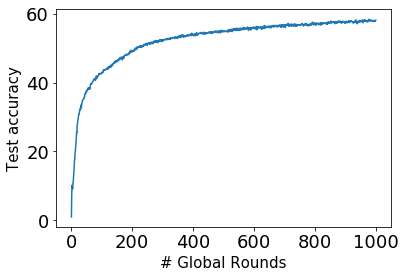

In [18]:
import matplotlib
step=1000
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
#plt.plot(range(len(Cluster0_minor1)), Cluster0_minor1,label="users=2,5,5,6,7")
plt.plot(range(len(acc_test_arr[0:step])), acc_test_arr[0:step],label="without sparsification")
plt.ylabel('Test accuracy')
plt.xlabel('# Global Rounds')
#plt.legend()
#plt.figure(figsize=(6,5), dpi=400)
plt.show()

In [ ]:
print(loss_train)

In [19]:
print(acc_test_arr[0:step])

[1.0071942806243896, 7.601918697357178, 10.19184684753418, 9.90407657623291, 9.136691093444824, 10.887290000915527, 10.983213424682617, 12.781774520874023, 13.812949180603027, 15.707433700561523, 17.31414794921875, 17.745803833007812, 19.832134246826172, 20.047962188720703, 21.67865753173828, 22.757793426513672, 23.669065475463867, 25.65947151184082, 25.491607666015625, 27.817745208740234, 27.96162986755371, 29.088729858398438, 29.400480270385742, 30.167865753173828, 30.791366577148438, 30.791366577148438, 31.19904136657715, 32.038368225097656, 31.942445755004883, 32.51798629760742, 32.47002410888672, 33.47721862792969, 32.589927673339844, 32.8776969909668, 34.00479507446289, 34.1966438293457, 34.60431671142578, 34.98801040649414, 35.035972595214844, 35.08393096923828, 35.20383834838867, 35.65947341918945, 35.63549041748047, 35.707435607910156, 36.66666793823242, 36.61870574951172, 36.76258850097656, 37.0743408203125, 37.434051513671875, 37.09832000732422, 37.48201370239258, 37.8417282

In [ ]:
print(max(acc_test_arr))

In [ ]:
print((w_glob))